In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud

In [2]:
df = pd.read_csv("customers-100000.csv")
df.columns

Index(['Index', 'Customer Id', 'First Name', 'Last Name', 'Company', 'City',
       'Country', 'Phone 1', 'Phone 2', 'Email', 'Subscription Date',
       'Website'],
      dtype='object')

In [3]:
df.shape[0] == df["Customer Id"].nunique()

True

In [42]:
df.isna().sum()

Index                0
Customer Id          0
First Name           0
Last Name            0
Company              0
City                 0
Country              0
Phone 1              0
Phone 2              0
Email                0
Subscription Date    0
Website              0
dtype: int64

/tmp/ipykernel_225004/1298975619.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


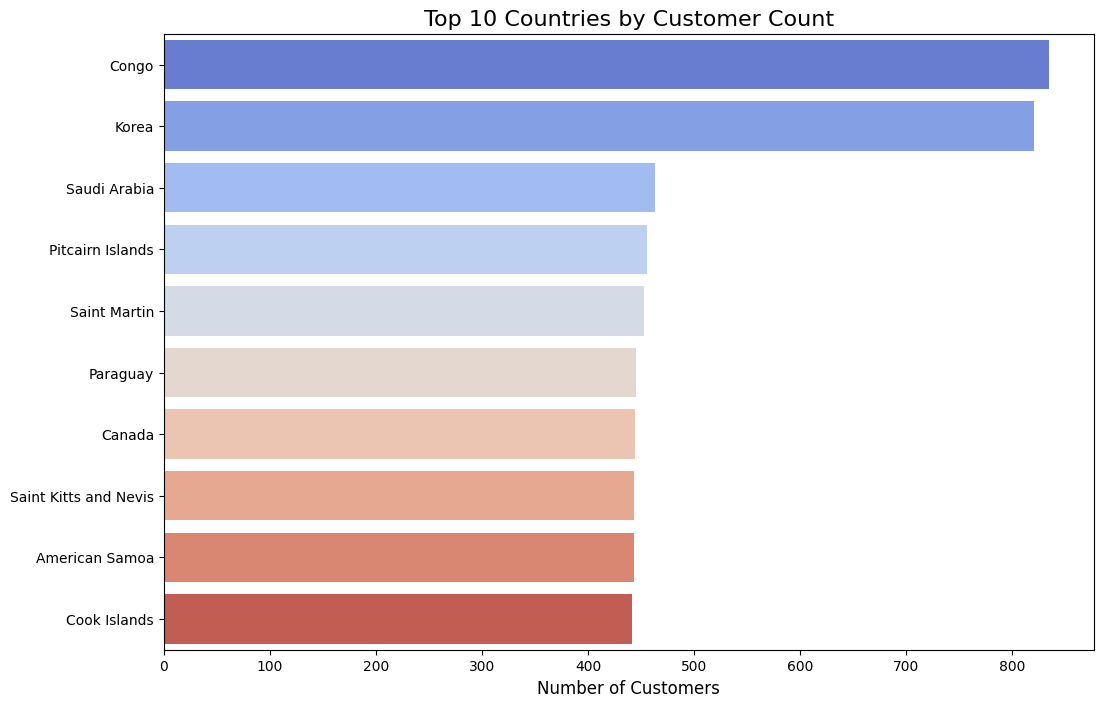

In [4]:
unique_customers = df.drop_duplicates(subset=["Customer Id"], keep="first")

top_countries = unique_customers["Country"].value_counts().head(10)
top_countries_df = pd.DataFrame(
    {
        "Country": top_countries.index,
        "Customer_Count": top_countries.values,
        "Percentage": (top_countries.values / len(unique_customers)) * 100,
    }
)

plt.figure(figsize=(12, 8))

ax = sns.barplot(
    data=top_countries_df,
    y="Country",
    x="Customer_Count",
    palette="coolwarm",
)

plt.title("Top 10 Countries by Customer Count", fontsize=16)
plt.xlabel("Number of Customers", fontsize=12)
plt.ylabel("")
plt.show()

In [5]:
unique_customers = df.drop_duplicates(subset=["Customer Id"], keep="first")
unique_customers["Subscription_Year"] = pd.to_datetime(
    unique_customers["Subscription Date"]
).dt.year

top_n = 10
yearly_country_counts = []
for year in sorted(unique_customers["Subscription_Year"].unique()):
    year_data = unique_customers[unique_customers["Subscription_Year"] == year]
    top_countries = year_data["Country"].value_counts().head(top_n)

    for rank, (country, count) in enumerate(top_countries.items(), 1):
        yearly_country_counts.append(
            {
                "Year": year,
                "Country": country,
                "Customer_Count": count,
                "Rank": rank,
                "Percentage": (count / len(year_data)) * 100,
            }
        )

yearly_top_countries = pd.DataFrame(yearly_country_counts)

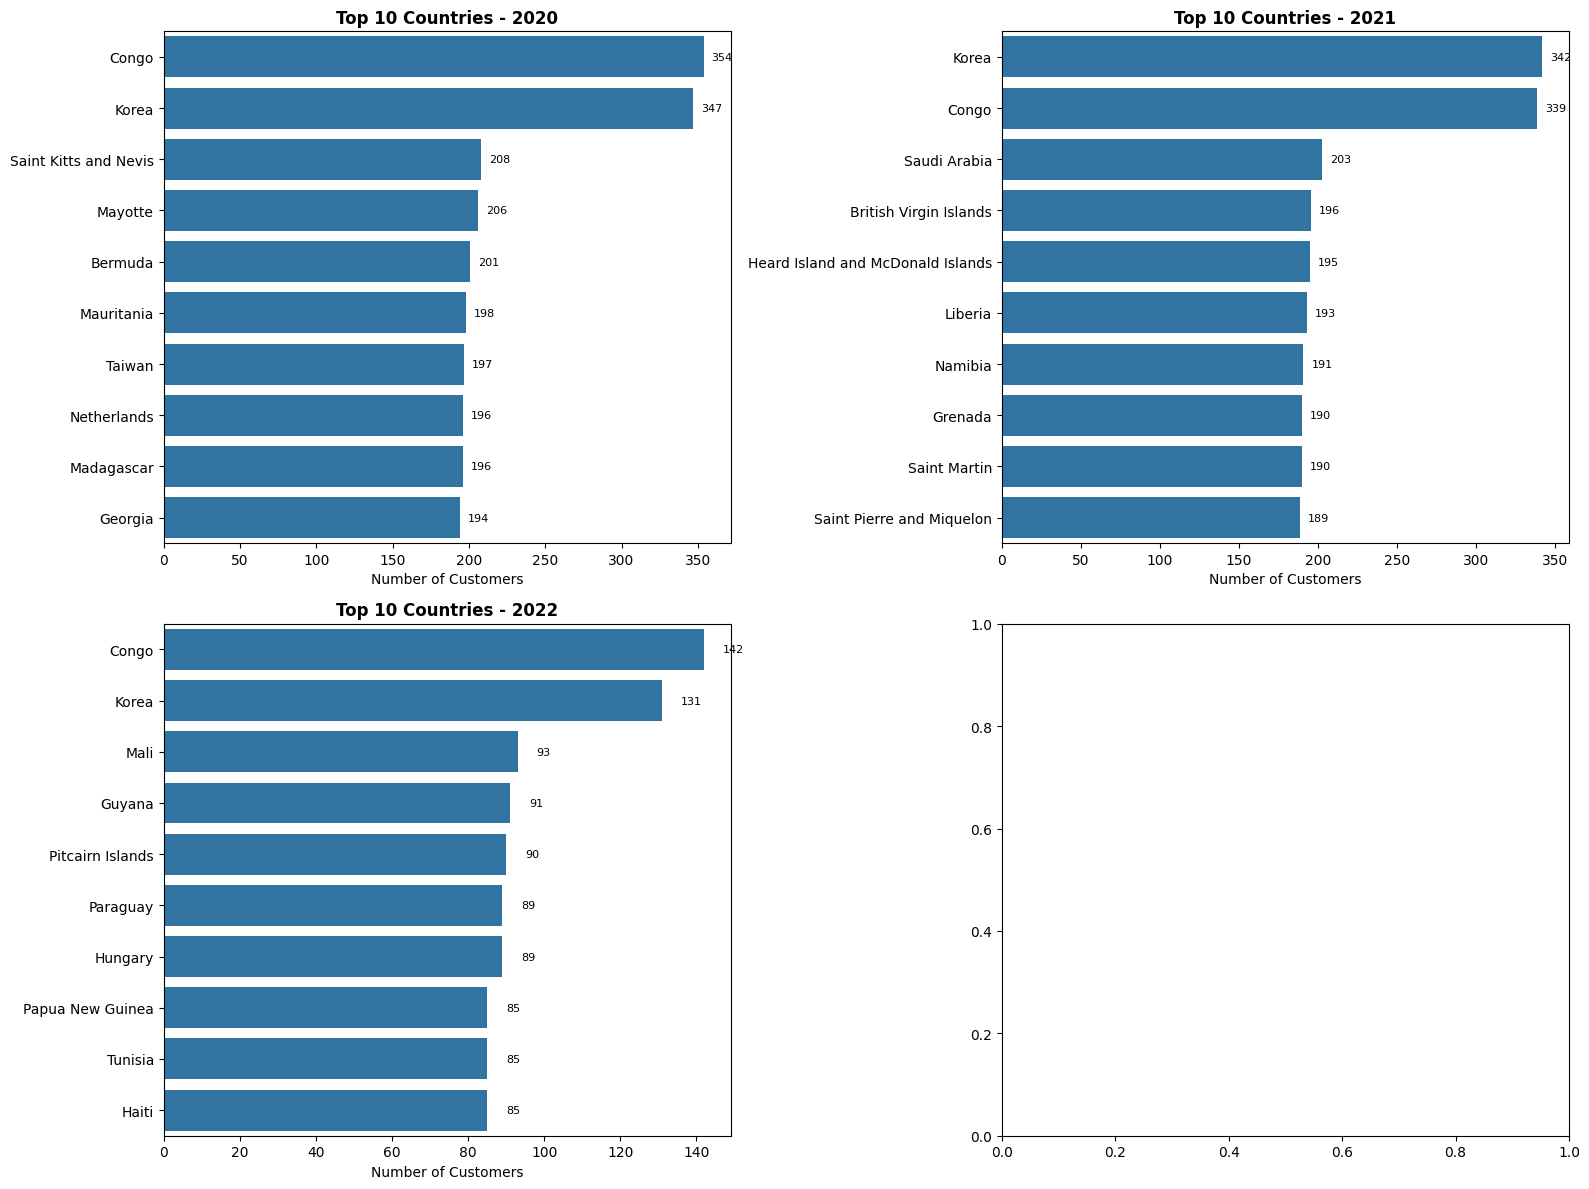

In [6]:
years = sorted(unique_customers["Subscription_Year"].unique())
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, year in enumerate(years):
    if i < len(axes):
        year_data = yearly_top_countries[yearly_top_countries["Year"] == year].head(10)

        sns.barplot(
            data=year_data,
            y="Country",
            x="Customer_Count",
            ax=axes[i],
        )

        axes[i].set_title(f"Top 10 Countries - {year}", fontweight="bold")
        axes[i].set_xlabel("Number of Customers")
        axes[i].set_ylabel("")

        for j, (idx, row) in enumerate(year_data.iterrows()):
            axes[i].text(
                row["Customer_Count"] + 5,
                j,
                f"{row['Customer_Count']:,}",
                va="center",
                ha="left",
                fontsize=8,
            )

plt.tight_layout()
plt.show()

In [7]:
df_analysis = df.copy()
df_analysis["Subscription_Date"] = pd.to_datetime(df_analysis["Subscription Date"])
df_analysis["Year"] = df_analysis["Subscription_Date"].dt.year
df_analysis["Month"] = df_analysis["Subscription_Date"].dt.month
df_analysis["Month_Name"] = df_analysis["Subscription_Date"].dt.strftime("%B")
df_analysis["Year_Month"] = df_analysis["Subscription_Date"].dt.to_period("M")

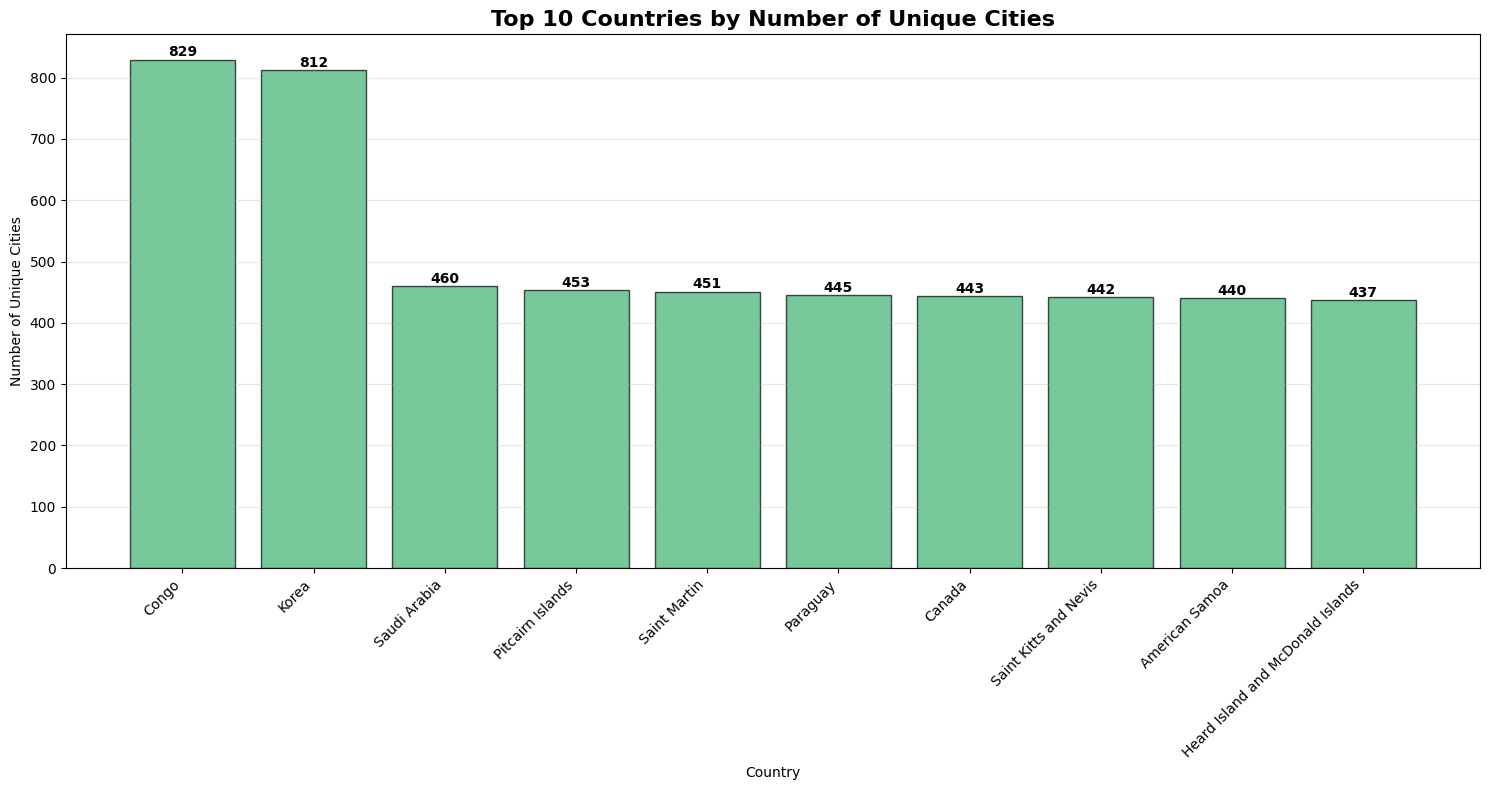

In [45]:
top_countries_by_cities = (
    df_analysis.groupby("Country")["City"]
    .nunique()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(15, 8))
bars = plt.bar(
    range(len(top_countries_by_cities)),
    top_countries_by_cities.values,
    color="mediumseagreen",
    edgecolor="black",
    alpha=0.7,
)

plt.title("Top 10 Countries by Number of Unique Cities", fontweight="bold", fontsize=16)
plt.xlabel("Country")
plt.ylabel("Number of Unique Cities")
plt.xticks(
    range(len(top_countries_by_cities)),
    top_countries_by_cities.index,
    rotation=45,
    ha="right",
)
plt.grid(True, alpha=0.3, axis="y")

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.5,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

plt.tight_layout()
plt.show()


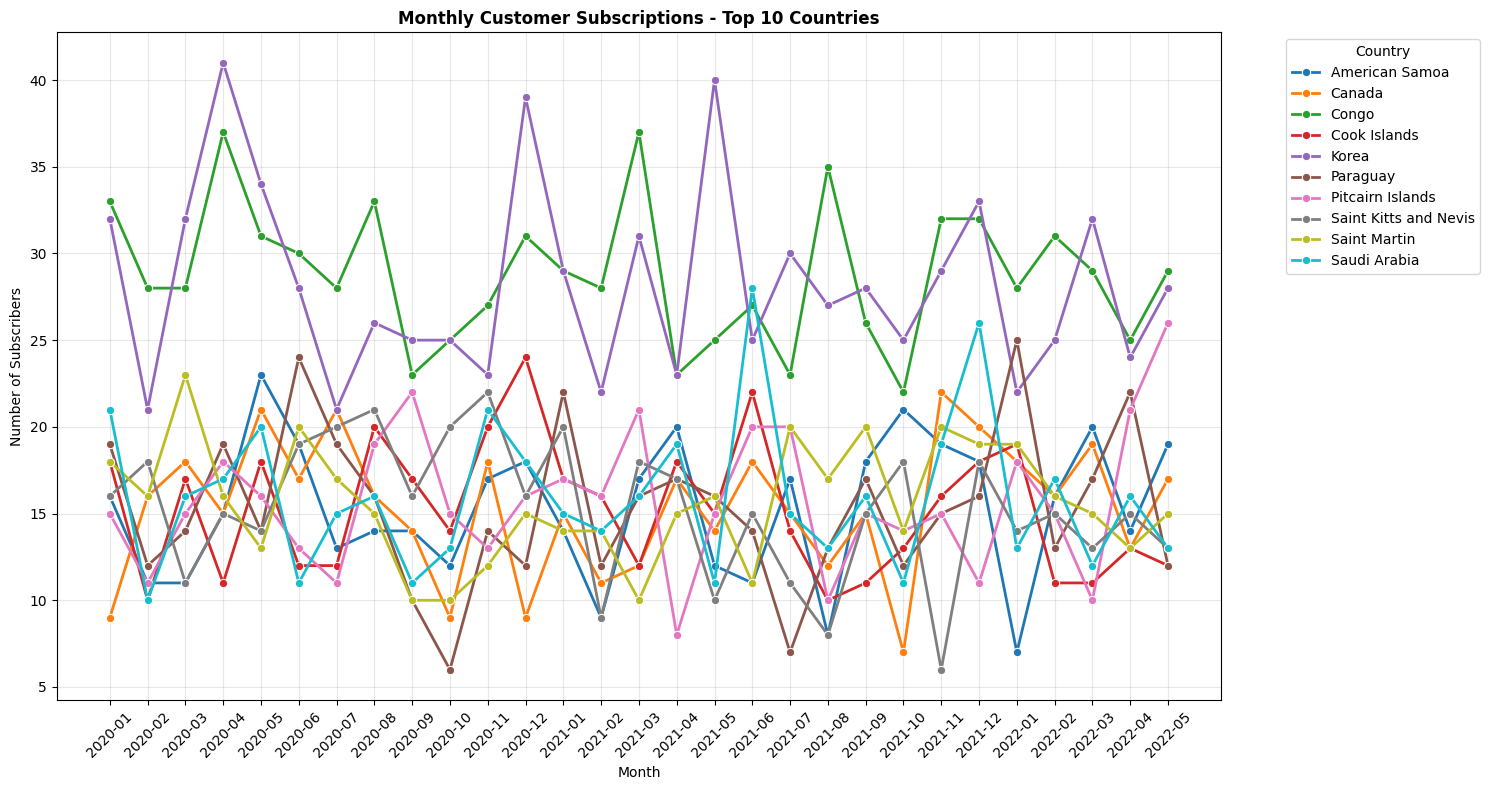

In [9]:
top_10_countries = df_analysis["Country"].value_counts().head(10).index.tolist()
df_top_10 = df_analysis[df_analysis["Country"].isin(top_10_countries)]

monthly_country_counts = (
    df_top_10.groupby(["Year_Month", "Country"])
    .size()
    .reset_index(name="Customer_Count")
)
monthly_country_counts["Year_Month_str"] = monthly_country_counts["Year_Month"].astype(
    str
)

plt.figure(figsize=(15, 8))

sns.lineplot(
    data=monthly_country_counts,
    x="Year_Month_str",
    y="Customer_Count",
    hue="Country",
    marker="o",
    linewidth=2,
    markersize=6,
)

plt.title("Monthly Customer Subscriptions - Top 10 Countries", fontweight="bold")
plt.xlabel("Month")
plt.ylabel("Number of Subscribers")
plt.xticks(rotation=45)
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


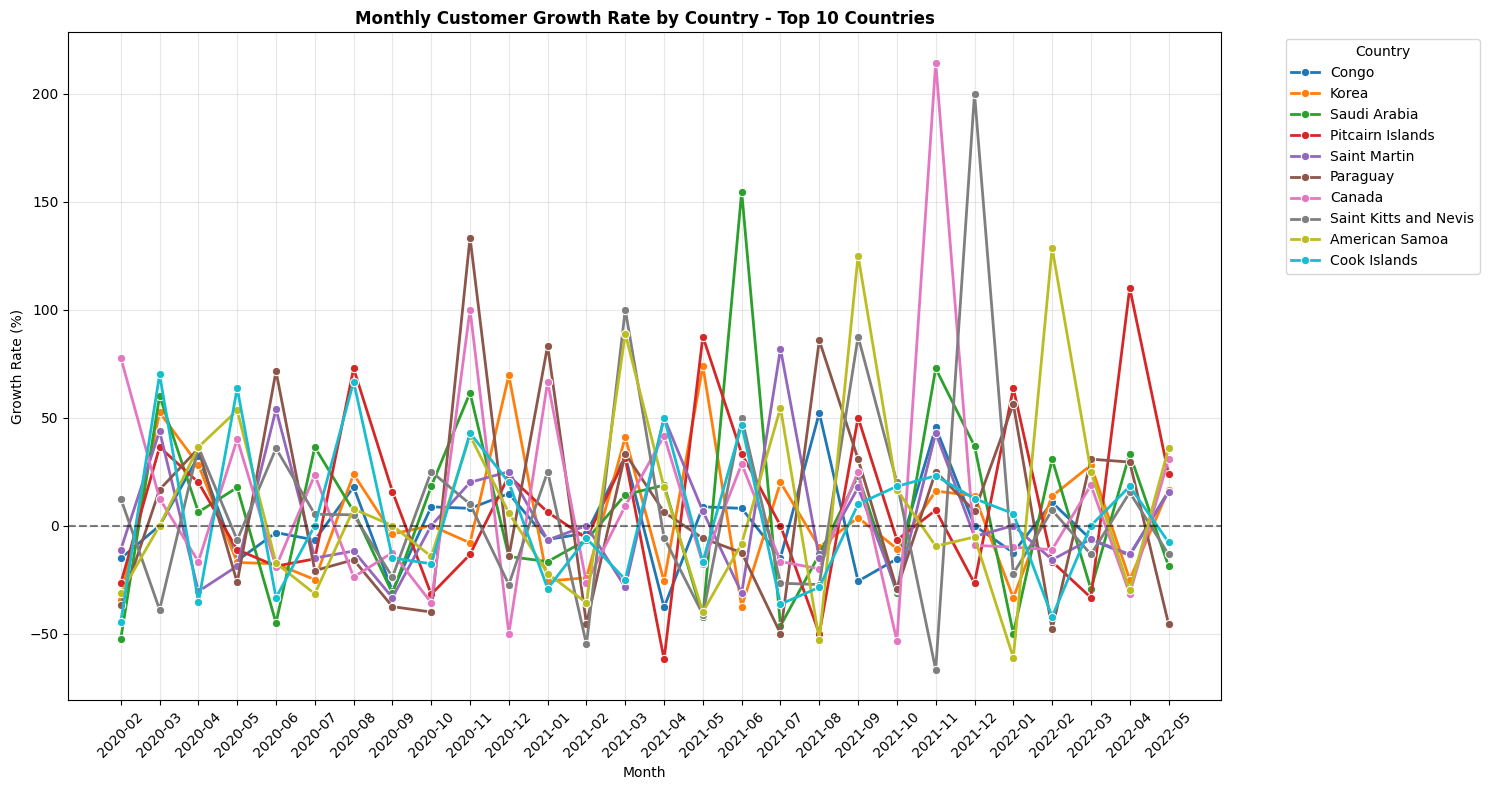

In [10]:
top_10_countries = df_analysis["Country"].value_counts().head(10).index.tolist()
df_top_10 = df_analysis[df_analysis["Country"].isin(top_10_countries)]

monthly_country_counts = (
    df_top_10.groupby(["Year_Month", "Country"])
    .size()
    .reset_index(name="Customer_Count")
)

growth_data = []
for country in top_10_countries:
    country_data = monthly_country_counts[
        monthly_country_counts["Country"] == country
    ].copy()
    country_data = country_data.sort_values("Year_Month")
    country_data["Growth_Percent"] = country_data["Customer_Count"].pct_change() * 100

    growth_data.append(country_data)

growth_df = pd.concat(growth_data, ignore_index=True)
growth_df["Year_Month_str"] = growth_df["Year_Month"].astype(str)

growth_df = growth_df.dropna(subset=["Growth_Percent"])

plt.figure(figsize=(15, 8))

sns.lineplot(
    data=growth_df,
    x="Year_Month_str",
    y="Growth_Percent",
    hue="Country",
    marker="o",
    linewidth=2,
    markersize=6,
)

plt.title(
    "Monthly Customer Growth Rate by Country - Top 10 Countries", fontweight="bold"
)
plt.xlabel("Month")
plt.ylabel("Growth Rate (%)")
plt.xticks(rotation=45)
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color="black", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


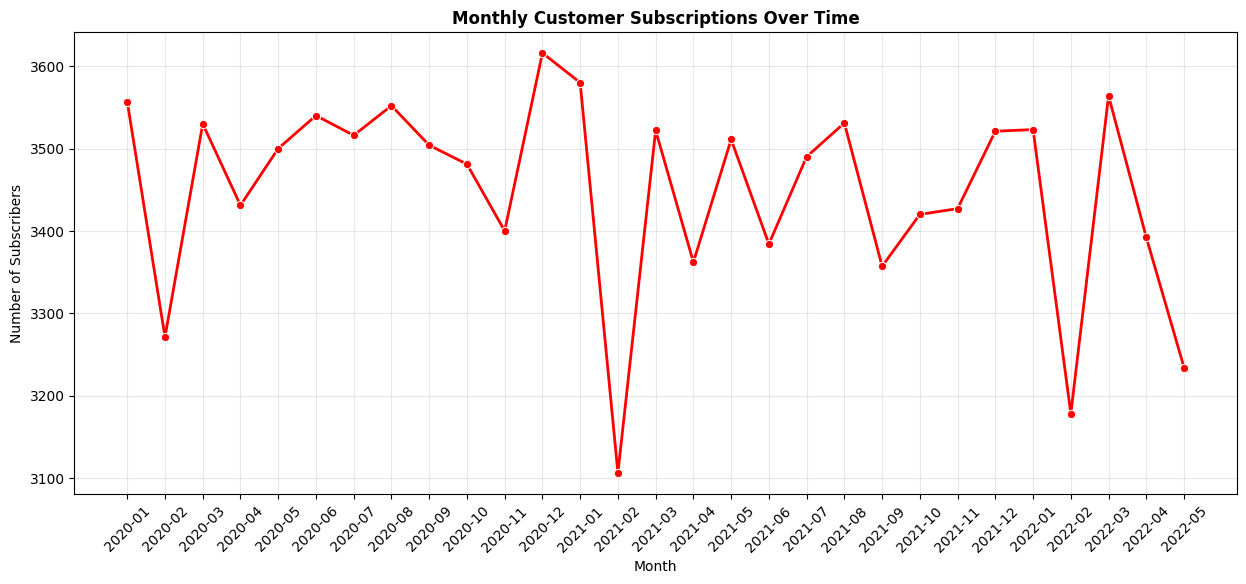

In [11]:
# Monthly subscription counts
monthly_counts = (
    df_analysis.groupby(["Year", "Month", "Month_Name"])
    .size()
    .reset_index(name="Customer_Count")
)

plt.figure(figsize=(15, 6))
monthly_totals = df_analysis.groupby("Year_Month").size()

x_values = monthly_totals.index.astype(str)
sns.lineplot(
    x=x_values,
    y=monthly_totals.values,
    marker="o",
    linewidth=2,
    markersize=6,
    color="red",
)

plt.title("Monthly Customer Subscriptions Over Time", fontweight="bold")
plt.xlabel("Month")
plt.ylabel("Number of Subscribers")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

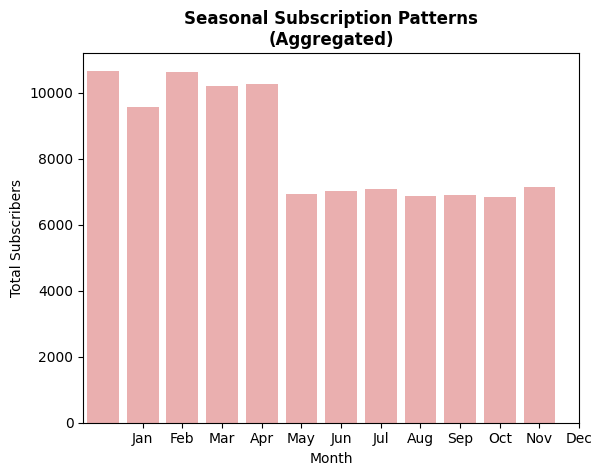

In [12]:
seasonal_data = df_analysis.groupby("Month").size()
month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]

sns.barplot(x=range(1, 13), y=seasonal_data.values, color="lightcoral", alpha=0.7)
plt.title("Seasonal Subscription Patterns\n(Aggregated)", fontweight="bold")
plt.xlabel("Month")
plt.ylabel("Total Subscribers")
plt.xticks(range(1, 13), month_names)
plt.show()

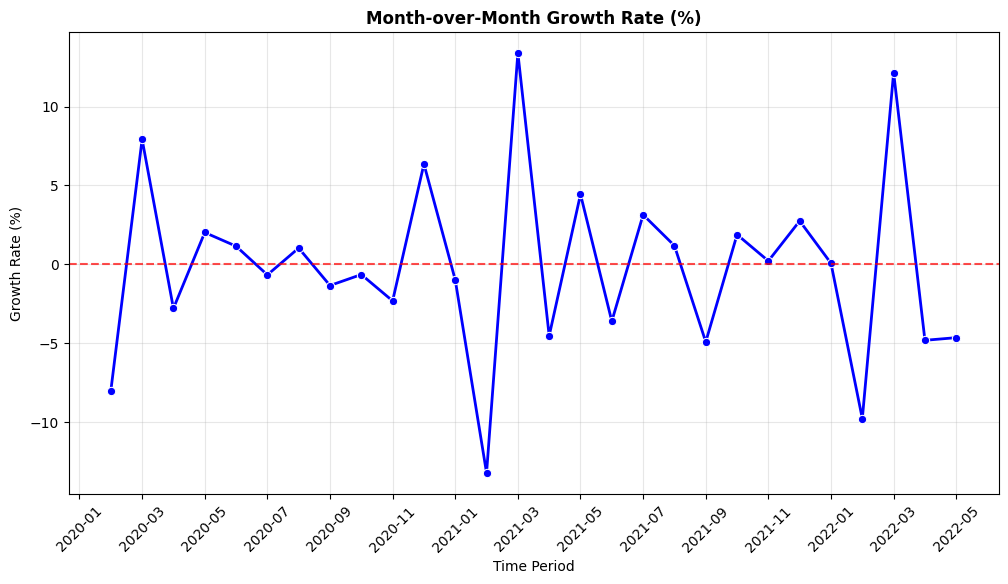

In [13]:
# Monthly growth rates
monthly_totals = (
    df_analysis.groupby("Year_Month").size().reset_index(name="Customer_Count")
)
monthly_totals["Year_Month_Str"] = monthly_totals["Year_Month"].astype(str)

monthly_totals["MoM_Growth_Rate"] = monthly_totals["Customer_Count"].pct_change() * 100
monthly_totals["MoM_Absolute_Growth"] = monthly_totals["Customer_Count"].diff()

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=monthly_totals,
    x=range(len(monthly_totals)),
    y="MoM_Growth_Rate",
    marker="o",
    linewidth=2,
    markersize=6,
    color="blue",
)
plt.axhline(y=0, color="red", linestyle="--", alpha=0.7)
plt.title("Month-over-Month Growth Rate (%)", fontweight="bold")
plt.xlabel("Time Period")
plt.ylabel("Growth Rate (%)")
plt.grid(True, alpha=0.3)
plt.xticks(
    range(0, len(monthly_totals), 2), monthly_totals["Year_Month_Str"][::2], rotation=45
)
plt.show()


In [14]:
def classify_company_type(company_name: str) -> str:
    if pd.isna(company_name):
        return "Unknown"

    company = str(company_name).strip()
    company_lower = company.lower()

    if company_lower.endswith("llc"):
        return "LLC"
    elif company_lower.endswith("plc"):
        return "PLC"
    elif company_lower.endswith("ltd"):
        return "Limited (Ltd)"
    elif company_lower.endswith("inc"):
        return "Incorporated (Inc)"
    elif "corp" in company_lower:
        return "Corporation"
    elif "group" in company_lower:
        return "Group"
    elif company_lower.endswith("and sons"):
        return "Family Business (& Sons)"
    elif "and co" in company_lower:
        return "Partnership (& Co)"
    else:
        return "Other"

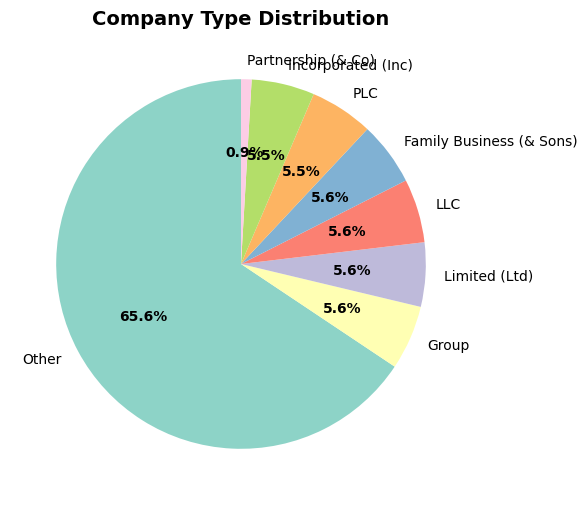

In [15]:
df_analysis["Company_Type"] = df_analysis["Company"].apply(classify_company_type)

company_type_counts = df_analysis["Company_Type"].value_counts()

plt.figure(figsize=(10, 6))
colors = sns.color_palette("Set3", len(company_type_counts))
wedges, texts, autotexts = plt.pie(
    company_type_counts.values,
    labels=company_type_counts.index,
    autopct="%1.1f%%",
    colors=colors,
    startangle=90,
)

for autotext in autotexts:
    autotext.set_color("black")
    autotext.set_fontweight("bold")

plt.title("Company Type Distribution", fontweight="bold", fontsize=14)
plt.show()


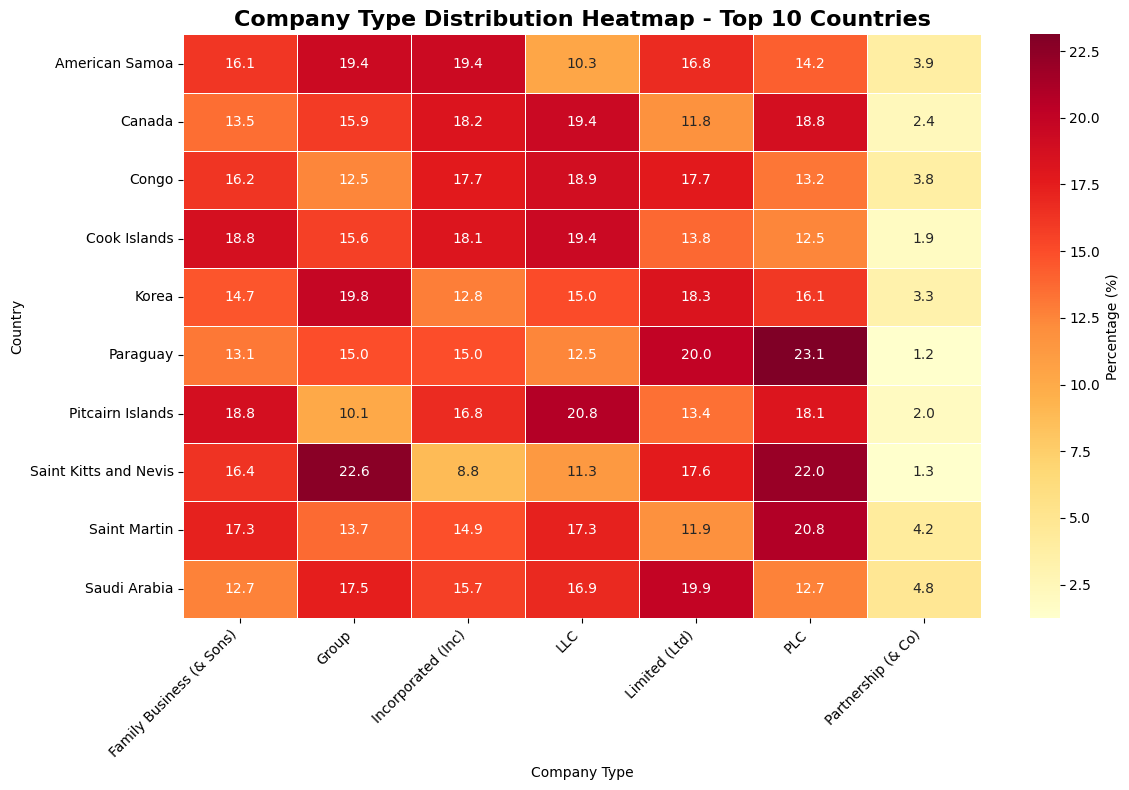

In [16]:
# By top 10 excluding Other
df_top_10 = df_analysis[df_analysis["Country"].isin(top_10_countries)]
df_top_10 = df_top_10[df_top_10["Company_Type"] != "Other"]
company_type_percentages = (
    pd.crosstab(df_top_10["Country"], df_top_10["Company_Type"], normalize="index")
    * 100
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    company_type_percentages,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    cbar_kws={"label": "Percentage (%)"},
    linewidths=0.5,
)
plt.title(
    "Company Type Distribution Heatmap - Top 10 Countries",
    fontweight="bold",
    fontsize=16,
)
plt.xlabel("Company Type")
plt.ylabel("Country")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [17]:
df_analysis["Email_Username"] = df_analysis["Email"].str.split("@").str[0].str.lower()
df_analysis["Email_Domain"] = df_analysis["Email"].str.split("@").str[1].str.lower()
df_analysis["First_Name_Lower"] = df_analysis["First Name"].str.lower()
df_analysis["Last_Name_Lower"] = df_analysis["Last Name"].str.lower()


def check_email_name_match(row):
    if (
        pd.isna(row["Email_Username"])
        or pd.isna(row["Email_Domain"])
        or pd.isna(row["First_Name_Lower"])
        or pd.isna(row["Last_Name_Lower"])
    ):
        return "Unknown"

    email_user = row["Email_Username"]
    email_domain = row["Email_Domain"]
    first_name = row["First_Name_Lower"]
    last_name = row["Last_Name_Lower"]

    if first_name + last_name == email_user:
        return "FirstLast Match"
    elif first_name + "." + last_name in email_user:
        return "First.Last Match"
    elif first_name + "_" + last_name in email_user:
        return "First_Last Match"
    elif first_name + last_name in email_user:
        return "LastFirst Match"
    elif email_domain in first_name + last_name:
        return "Domain Match"
    elif email_user == first_name:
        return "First Name Only"
    elif email_user == last_name:
        return "Last Name Only"
    elif email_domain == first_name:
        return "Domain First Name Only"
    elif email_domain == last_name:
        return "Domain Last Name Only"
    else:
        return "No Match"

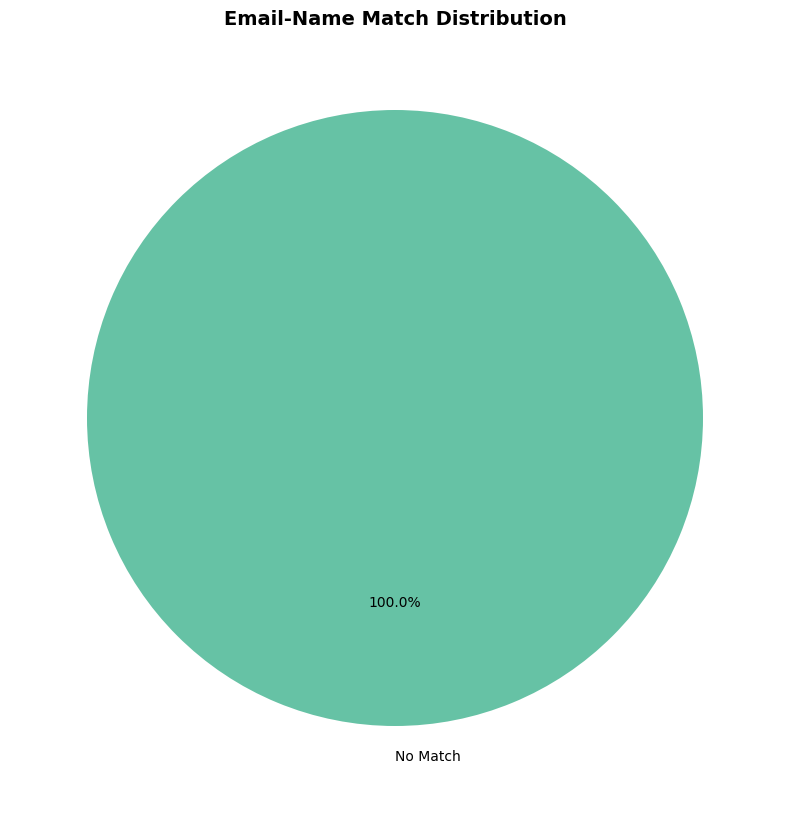

In [18]:
df_analysis["Email_Name_Match"] = df_analysis.apply(check_email_name_match, axis=1)
match_counts = df_analysis["Email_Name_Match"].value_counts()

plt.figure(figsize=(16, 10))
colors = sns.color_palette("Set2", len(match_counts))
wedges, texts, autotexts = plt.pie(
    match_counts.values,
    labels=match_counts.index,
    autopct="%1.1f%%",
    colors=colors,
    startangle=90,
)

plt.title("Email-Name Match Distribution", fontweight="bold", fontsize=14)
plt.show()


In [19]:
def check_email_company_match(row):
    if (
        pd.isna(row["Email_Username"])
        or pd.isna(row["Email_Domain"])
        or pd.isna(row["Company"])
    ):
        return "Unknown"

    email_user = row["Email_Username"]
    email_domain = row["Email_Domain"]
    company = str(row["Company"]).lower()

    company_clean = company
    suffixes_to_remove = [
        " llc",
        " inc",
        " ltd",
        " plc",
        " corp",
        " group",
        " co",
        " and sons",
        " & sons",
    ]

    for suffix in suffixes_to_remove:
        if company_clean.endswith(suffix):
            company_clean = company_clean[: -len(suffix)].strip()

    company_no_spaces = company_clean.replace(" ", "").replace("-", "").replace(",", "")
    company_hyphenated = company_clean.replace(" ", "-")
    company_underscored = company_clean.replace(" ", "_")

    if company_no_spaces == email_user:
        return "Exact Company Match"
    elif company_hyphenated in email_user:
        return "Company Hyphenated Match"
    elif company_underscored in email_user:
        return "Company Underscored Match"
    elif company_clean.replace(" ", "") in email_user:
        return "Company Partial Match"
    elif company_no_spaces in email_domain:
        return "Company in Domain"
    elif any(word in email_domain for word in company_clean if len(word) > 3):
        return "Company Word in Domain"
    elif any(word in email_user for word in company_clean if len(word) > 3):
        return "Company Word in Username"
    elif any(word in email_domain for word in company_clean if len(word) > 3):
        return "Company Word in Domain"
    else:
        return "No Company Match"

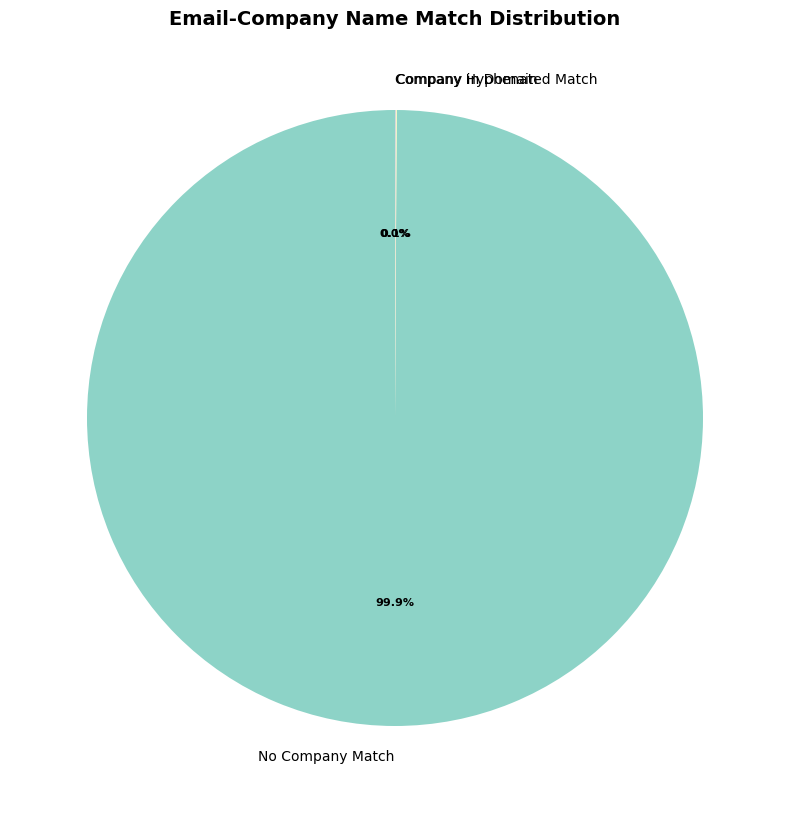

In [20]:
df_analysis["Email_Company_Match"] = df_analysis.apply(
    check_email_company_match, axis=1
)
company_match_counts = df_analysis["Email_Company_Match"].value_counts()

plt.figure(figsize=(16, 10))
colors = sns.color_palette("Set3", len(company_match_counts))
wedges, texts, autotexts = plt.pie(
    company_match_counts.values,
    labels=company_match_counts.index,
    autopct="%1.1f%%",
    colors=colors,
    startangle=90,
)

for autotext in autotexts:
    autotext.set_fontsize(8)
    autotext.set_fontweight("bold")

plt.title("Email-Company Name Match Distribution", fontweight="bold", fontsize=14)
plt.show()


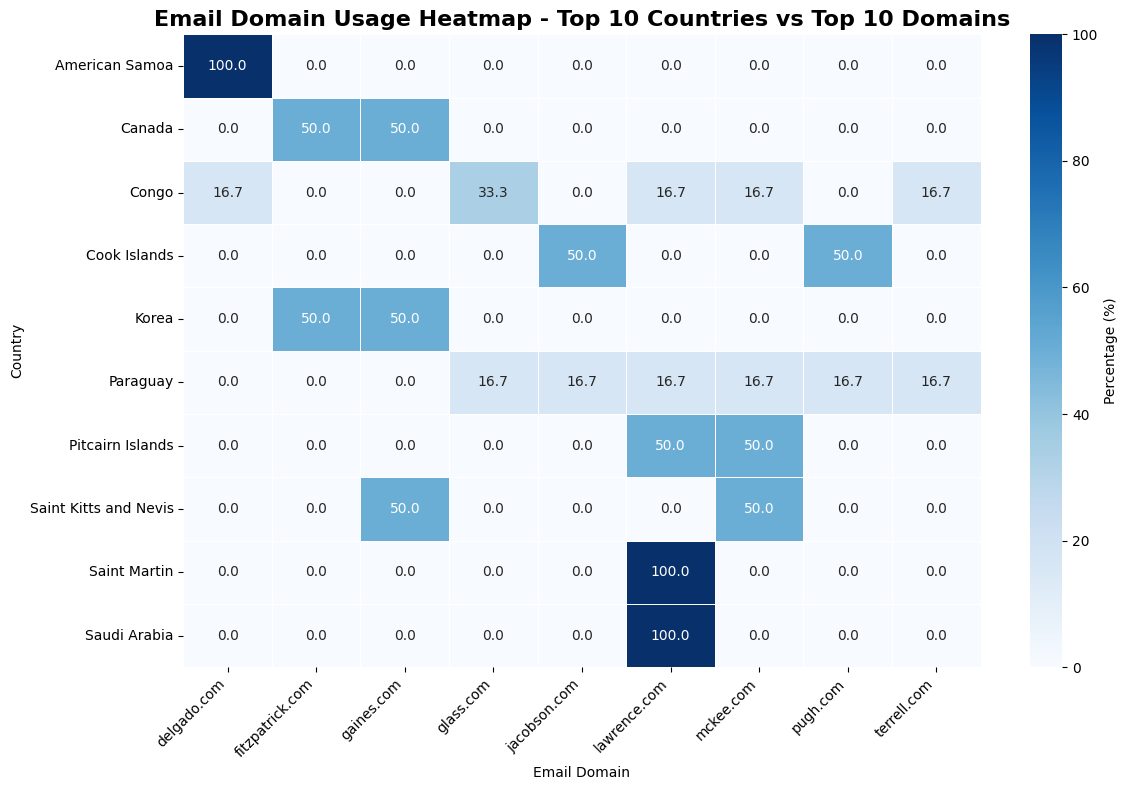

In [21]:
top_10_domains = df_analysis["Email_Domain"].value_counts().head(10).index.tolist()

df_filtered = df_analysis[
    (df_analysis["Country"].isin(top_10_countries))
    & (df_analysis["Email_Domain"].isin(top_10_domains))
]

domain_percentages = (
    pd.crosstab(df_filtered["Country"], df_filtered["Email_Domain"], normalize="index")
    * 100
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    domain_percentages,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    cbar_kws={"label": "Percentage (%)"},
    linewidths=0.5,
)
plt.title(
    "Email Domain Usage Heatmap - Top 10 Countries vs Top 10 Domains",
    fontweight="bold",
    fontsize=16,
)
plt.xlabel("Email Domain")
plt.ylabel("Country")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [22]:
def extract_protocol(url: str) -> str:
    url = url.lower().strip()
    if url.startswith("https://"):
        return "HTTPS"
    elif url.startswith("http://"):
        return "HTTP"


df_analysis["Website_Protocol"] = df_analysis["Website"].apply(extract_protocol)


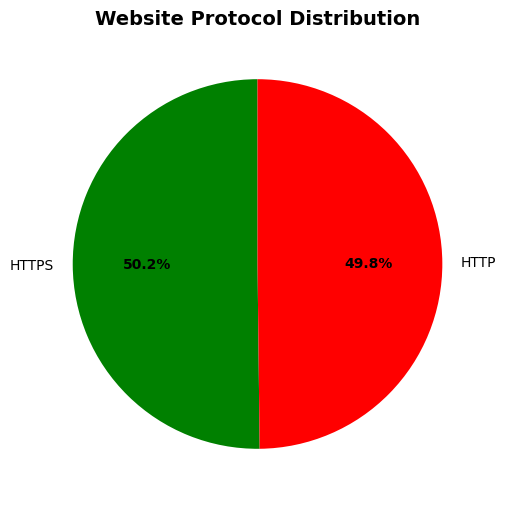

In [23]:
protocol_counts = df_analysis["Website_Protocol"].value_counts()

plt.figure(figsize=(12, 6))

colors = ["green", "red"]
wedges, texts, autotexts = plt.pie(
    protocol_counts.values,
    labels=protocol_counts.index,
    autopct="%1.1f%%",
    colors=colors,
    startangle=90,
)
for autotext in autotexts:
    autotext.set_color("black")
    autotext.set_fontweight("bold")
plt.title("Website Protocol Distribution", fontweight="bold", fontsize=14)
plt.show()


<Figure size 1500x800 with 0 Axes>

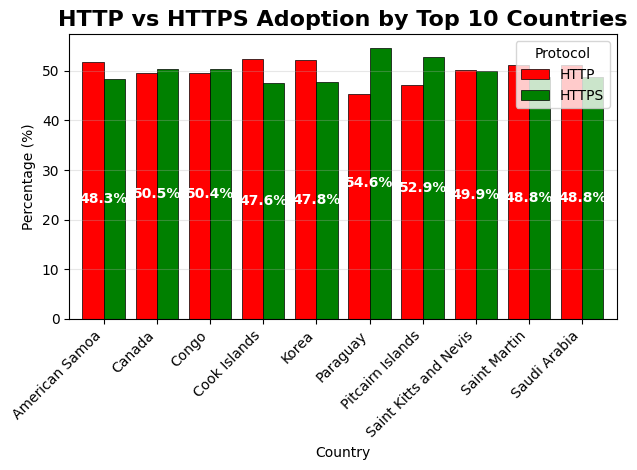

In [24]:
df_top_10 = df_analysis[df_analysis["Country"].isin(top_10_countries)]

protocol_by_country = pd.crosstab(df_top_10["Country"], df_top_10["Website_Protocol"])
protocol_percentages = (
    protocol_by_country.div(protocol_by_country.sum(axis=1), axis=0) * 100
)

# https_adoption = protocol_by_country[['HTTP', 'HTTPS']].copy()
https_adoption_pct = (
    protocol_by_country.div(protocol_by_country.sum(axis=1), axis=0) * 100
)

plt.figure(figsize=(15, 8))
https_adoption_pct.plot(
    kind="bar", color=["red", "green"], edgecolor="black", linewidth=0.5, width=0.8
)
plt.title("HTTP vs HTTPS Adoption by Top 10 Countries", fontweight="bold", fontsize=16)
plt.xlabel("Country")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Protocol", labels=["HTTP", "HTTPS"])
plt.grid(True, alpha=0.3, axis="y")

# Add HTTPS percentage labels on bars
for i, country in enumerate(https_adoption_pct.index):
    if "HTTPS" in https_adoption_pct.columns:
        https_pct = https_adoption_pct.loc[country, "HTTPS"]
        plt.text(
            i,
            https_pct / 2,
            f"{https_pct:.1f}%",
            ha="center",
            va="center",
            fontweight="bold",
            color="white",
        )

plt.tight_layout()
plt.show()

In [28]:
def extract_domain(url: str) -> str:
    url = url.lower().strip()
    url = url.replace("https://", "").replace("http://", "")
    url = url.replace("www.", "")
    domain = url.split("/")[0].split("?")[0]
    domain = domain.split(".")[-1]
    return domain


df_analysis["Website_Domain"] = df_analysis["Website"].apply(extract_domain)

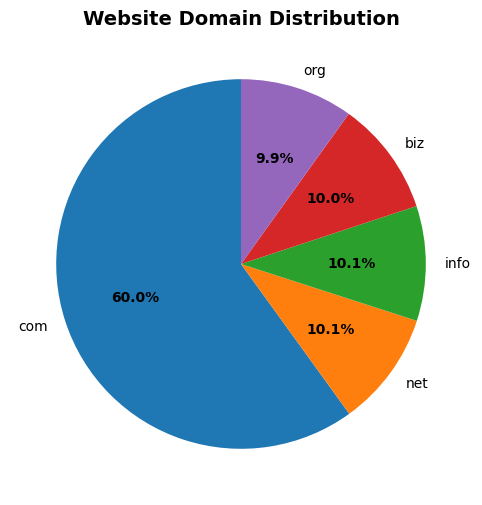

In [ ]:
domain_counts = df_analysis["Website_Domain"].value_counts()

plt.figure(figsize=(12, 6))

wedges, texts, autotexts = plt.pie(
    domain_counts.values,
    labels=domain_counts.index,
    autopct="%1.1f%%",
    startangle=90,
)
for autotext in autotexts:
    autotext.set_color("black")
    autotext.set_fontweight("bold")
plt.title("Website Domain Distribution", fontweight="bold", fontsize=14)
plt.show()

<Figure size 1500x800 with 0 Axes>

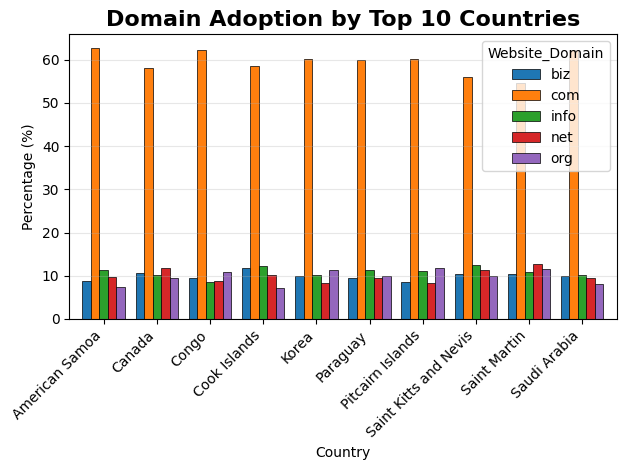

In [ ]:
df_top_10 = df_analysis[df_analysis["Country"].isin(top_10_countries)]

domain_by_country = pd.crosstab(df_top_10["Country"], df_top_10["Website_Domain"])

# https_adoption = domain_by_country[['HTTP', 'HTTPS']].copy()
https_adoption_pct = domain_by_country.div(domain_by_country.sum(axis=1), axis=0) * 100

plt.figure(figsize=(15, 8))
https_adoption_pct.plot(kind="bar", edgecolor="black", linewidth=0.5, width=0.8)
plt.title("Domain Adoption by Top 10 Countries", fontweight="bold", fontsize=16)
plt.xlabel("Country")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45, ha="right")
plt.grid(True, alpha=0.3, axis="y")

# Add HTTPS percentage labels on bars
for i, country in enumerate(https_adoption_pct.index):
    if "HTTPS" in https_adoption_pct.columns:
        https_pct = https_adoption_pct.loc[country, "HTTPS"]
        plt.text(
            i,
            https_pct / 2,
            f"{https_pct:.1f}%",
            ha="center",
            va="center",
            fontweight="bold",
            color="white",
        )

plt.tight_layout()
plt.show()

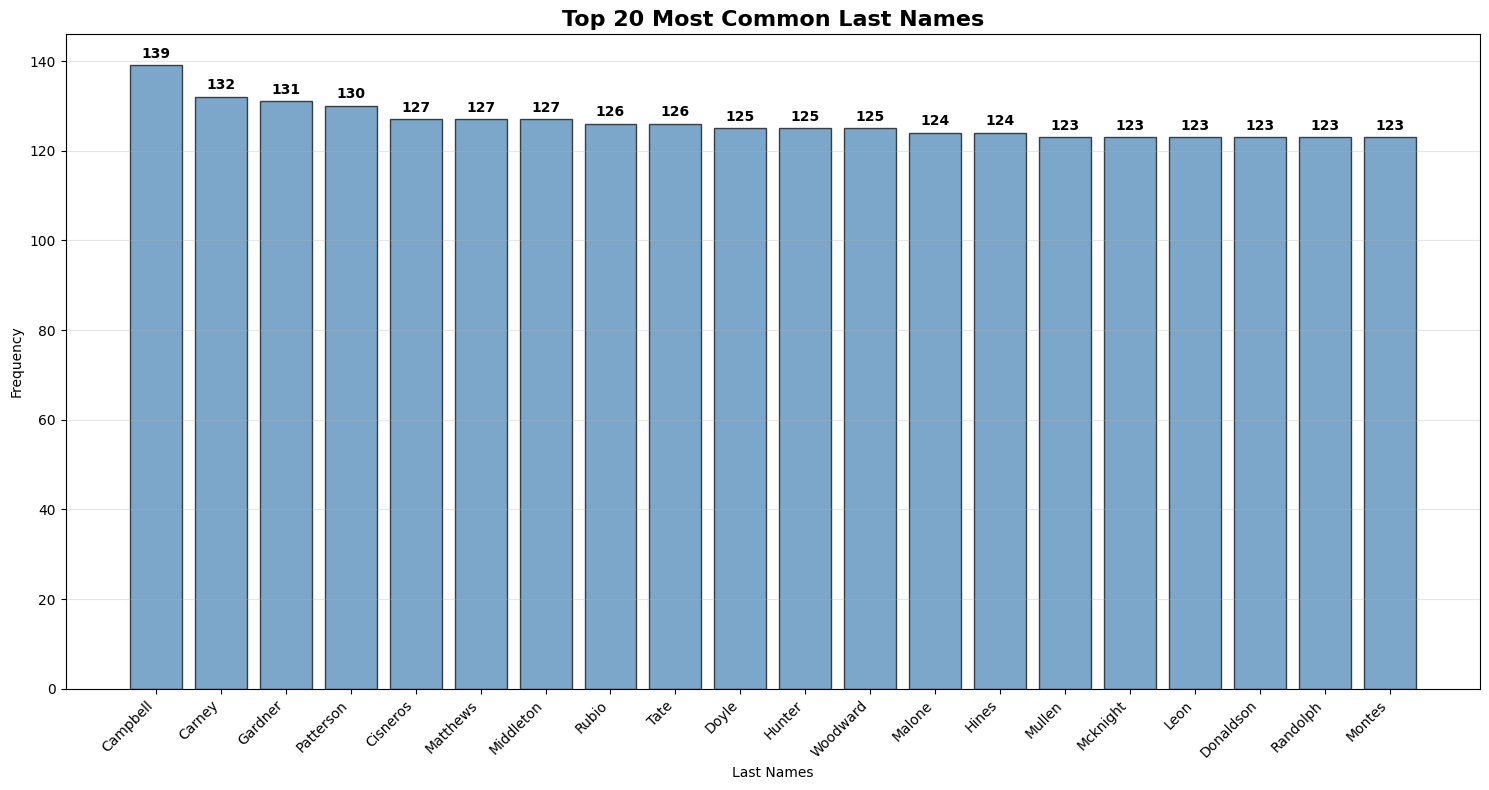

In [38]:
top_last_names = df_analysis["Last Name"].value_counts().head(20)

plt.figure(figsize=(15, 8))
bars = plt.bar(
    range(len(top_last_names)),
    top_last_names.values,
    color="steelblue",
    edgecolor="black",
    alpha=0.7,
)

plt.title("Top 20 Most Common Last Names", fontweight="bold", fontsize=16)
plt.xlabel("Last Names")
plt.ylabel("Frequency")
plt.xticks(range(len(top_last_names)), top_last_names.index, rotation=45, ha="right")
plt.grid(True, alpha=0.3, axis="y")

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 1,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

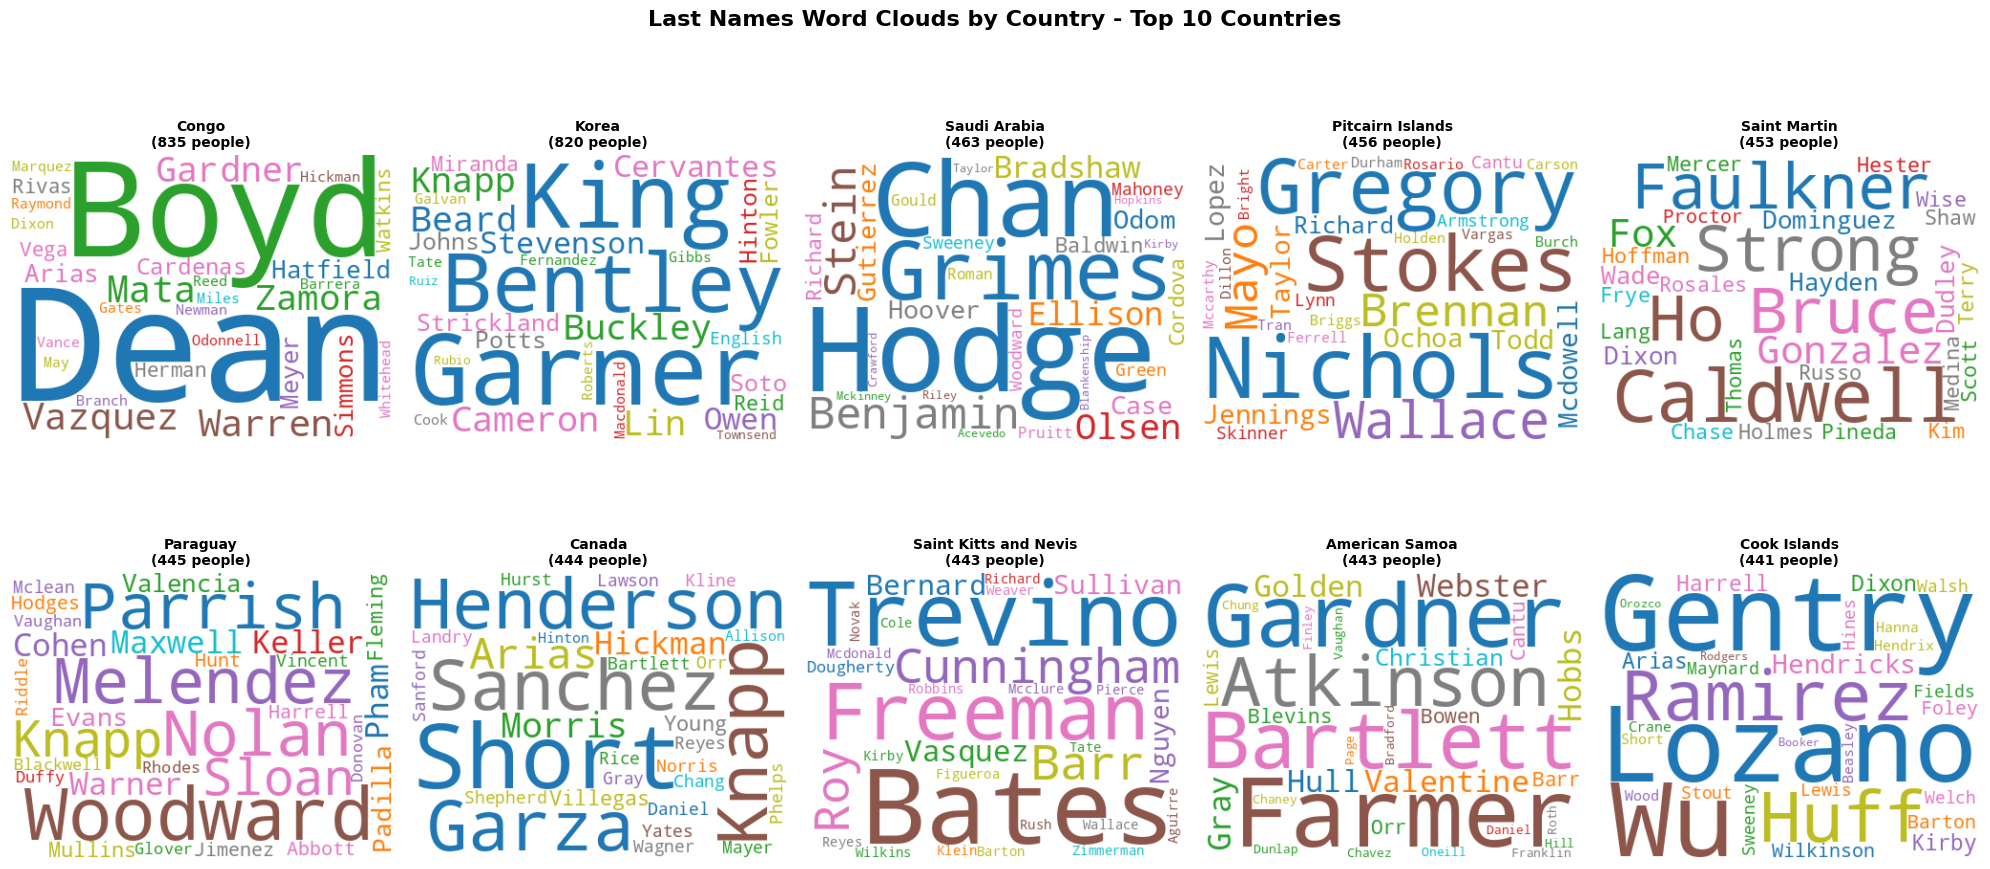

In [40]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for i, country in enumerate(top_10_countries):
    country_data = df_analysis[df_analysis["Country"] == country]
    top_names = country_data['Last Name'].value_counts().head(10)
    
    # Create word cloud for each country
    if len(top_names) > 0:
        last_names_text = ' '.join(country_data['Last Name'].dropna().astype(str))
        
        try:
            wordcloud = WordCloud(
                width=400, 
                height=300, 
                background_color='white',
                max_words=30,
                colormap='tab10',
                relative_scaling=0.5,
                random_state=42
            ).generate(last_names_text)
            
            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].axis('off')
            axes[i].set_title(f'{country}\n({len(country_data)} people)', fontweight='bold', fontsize=10)
        except Exception:
            # Fallback to bar chart if word cloud fails
            top_names.head(5).plot(kind='bar', ax=axes[i])
            axes[i].set_title(f'{country}', fontweight='bold', fontsize=10)
            axes[i].tick_params(axis='x', rotation=45, labelsize=8)

plt.suptitle('Last Names Word Clouds by Country - Top 10 Countries', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()